In [1]:
!python --version

Python 3.9.19


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time
from tqdm import trange
#  from torchsummary import summary
from torch.nn.parameter import Parameter
from torch.optim import SGD, Optimizer
from typing import List

import torchvision
import torchvision.transforms as transforms

In [3]:
# Hyperparameters for training
num_rounds = 50
local_rounds = 10
num_clients = 10  # Total number of clients
num_selected = 10  # Number of selected clients per round
local_bs = 10
lr = 0.001
num_channels = 3
num_classes = 10
test_bs = 128
gpu = 1
gamma = 0.1
milestones = [0.5 * num_rounds, 0.75 * num_rounds]

momentum = 0.9
weight_decay = 0.00001
mu = 0.01

In [4]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=4)

In [6]:
#ResNet9
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [7]:
class ResNet9(nn.Module):
    def __init__(
            self,
            in_channels,
            num_classes):
        super(ResNet9, self).__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [8]:
class CIFAR10_truncated(Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = datasets.CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        data = np.array(cifar_dataobj.data)
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [9]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

In [10]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])

In [11]:
# CIFAR10 Data loading
train_dataset = CIFAR10_truncated('./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10_truncated('./data', train=False, download=True, transform=transform_test)

X_train, y_train = train_dataset.data, train_dataset.target
X_test, y_test = test_dataset.data, test_dataset.target

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def record_net_data_stats(y_train, net_dataidx_map):

    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    #print('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [13]:
# for IID case
def generate_iid_cifar(X_train,y_train, num_of_clients):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param n_nets: Number of clients
    :return: Tuple containing train and test datasets, data index map for each client, and train data class counts
    """

    n_train = X_train.shape[0]

    # Shuffle and partition the data
    idxs = np.arange(n_train)
    np.random.shuffle(idxs)

    net_data_idx_map = {}
    batch_idxs = np.array_split(idxs, num_of_clients)

    for i in range(num_of_clients):
        net_data_idx_map[i] = batch_idxs[i]

    traindata_class_counts = record_net_data_stats(y_train, net_data_idx_map)

    return net_data_idx_map, traindata_class_counts

In [14]:
def generate_noniid_cifar(X_train,y_train, num_of_clients, alpha=0.5):
    """
    Sample non I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """

    n_train = len(X_train.shape)

    min_size = 0
    K = 10
    N = len(y_train)
    net_dataidx_map = {}

    while min_size < 10:
        idx_batch = [[] for _ in range(num_of_clients)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, num_of_clients))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/num_of_clients) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(num_of_clients):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = idx_batch[j]
    traindata_class_counts = record_net_data_stats(y_train, net_dataidx_map)

    return net_dataidx_map, traindata_class_counts

In [15]:
noniid_dataidx_map, noniid_traindata_cls_counts = generate_noniid_cifar(X_train,y_train, num_clients)

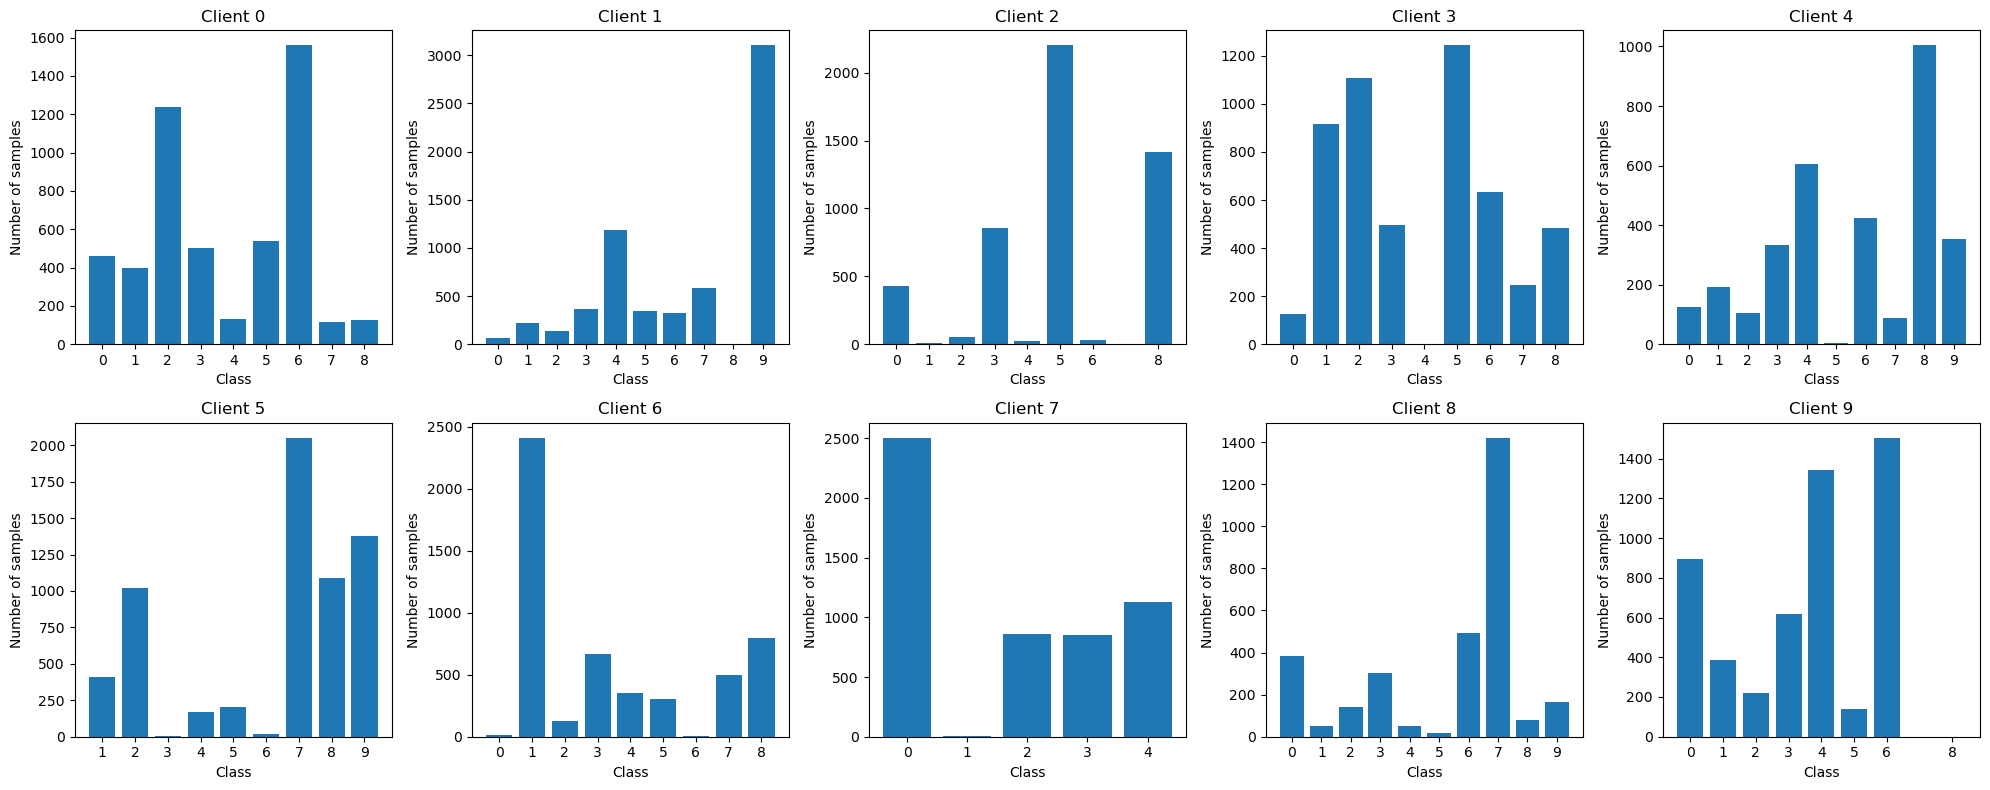

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import Counter

# Assuming you have already run the partition_data function and obtained the following:
# X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts

def visualize_client_distribution(traindata_cls_counts, n_clients):
    """
    Visualizes the class distribution for each client.
    
    :param traindata_cls_counts: Dictionary of class counts per client
    :param n_clients: Number of clients
    """
    fig, axes = plt.subplots(n_clients // 5, 5, figsize=(20, 4 * (n_clients // 5)))
    axes = axes.flatten()

    for client_id, cls_counts in traindata_cls_counts.items():
        classes = list(cls_counts.keys())
        counts = list(cls_counts.values())

        axes[client_id].bar(classes, counts)
        axes[client_id].set_xticks(classes)
        axes[client_id].set_xticklabels(classes)
        axes[client_id].set_title(f'Client {client_id}')
        axes[client_id].set_xlabel('Class')
        axes[client_id].set_ylabel('Number of samples')

    plt.tight_layout()
    plt.show()

# Visualize the distribution of the class counts for each client
visualize_client_distribution(noniid_traindata_cls_counts, num_clients)

In [17]:
# Client training function
def client_train(global_mod:nn.Module, net: nn.Module,
    loader: DataLoader,
    device: torch.device,
    local_rounds: int,
    proximal_mu: float,
    learning_rate: float,
    momentum: float,
    weight_decay: float):

    epoch_loss = []
    epoch_acc = []
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(
        net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
    )
    global_params = [param.detach().clone() for param in global_mod.parameters()]
    net.train()
    for _ in trange(local_rounds):
        batch_loss = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            proximal_term = 0.0
            for param, global_param in zip(net.parameters(), global_params):
                proximal_term += torch.norm(param - global_param) ** 2
            loss += (proximal_mu / 2) * proximal_term
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, pred = torch.max(output, dim=1)
            correct_train = pred.eq(target.data.view_as(pred))
            accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
            epoch_acc.append(accuracy_train.item())

        epoch_loss.append(sum(batch_loss) / len(batch_loss))
    return net.state_dict(), sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

In [18]:
# 'FedAvg' aggregation
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [19]:
# Evaluate on Test dataset
def evaluate(global_model, datatest, test_bs, device):
    global_model.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_bs)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            log_probs = global_model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)
                                 ).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss

In [20]:
# Initialize and synchronize models###
global_model = ResNet9(
    in_channels=num_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [21]:
trained_weights = global_model.state_dict()
shapes = {key: tensor.shape for key, tensor in trained_weights.items()}
sizes = {key: tensor.numel() for key, tensor in trained_weights.items()}

clients_models = {i: ResNet9(in_channels=num_channels, num_classes=num_classes).to(device) for i in range(num_clients)}
optimizers={}
for key, model in clients_models.items():
   optimizers[key] =  torch.optim.Adam(model.parameters(), lr=lr)

schedulers={}
for key, optimizer in optimizers.items():
   schedulers[key] =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [22]:
clients_models.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
   global_model, test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3034, Test Accuracy: 8.26%


In [24]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3069, Test Accuracy: 10.00%


In [25]:
for model in clients_models.values():
  model.load_state_dict(global_model.state_dict())

In [26]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3034, Test Accuracy: 8.26%


In [27]:
from collections import OrderedDict
def flatten_resnet_parameters(state_dict):
    """
    Flatten and concatenate all parameters from a state_dict into a single vector.
    """
    flat_params = torch.cat([p.view(-1).float() for p in state_dict.values()])
    return flat_params

def reconstruct_parameters(flat_params, shapes, sizes, trained_weights):
    """
    Reconstruct the original tensors from a flattened parameter tensor.

    :param flat_params: 1D tensor containing all weights concatenated
    :param shapes: Dictionary of parameter names to their shapes
    :param sizes: Dictionary of parameter names to their sizes (number of elements)
    :param trained_weights: Original state_dict containing the data types
    :return: OrderedDict of reconstructed tensors with their original shapes and types
    """
    reconstructed_params = OrderedDict()
    offset = 0
    for key in shapes:
        num_elements = sizes[key]
        # Extract the relevant slice from the flattened tensor
        param_slice = flat_params[offset:offset + num_elements]
        # Reshape it according to the original shape and convert to the original data type
        reconstructed_params[key] = param_slice.view(shapes[key])
        offset += num_elements
    return reconstructed_params

In [28]:
def segment_resnet_parameters(flat_params, num_segments):
    """
    Divide the flat parameters into equal segments, ensuring all elements are included.
    """
    total_len = len(flat_params)
    segment_size = total_len // num_segments
    remainder = total_len % num_segments

    segments = []
    start = 0
    for i in range(num_segments):
        # Calculate end point for the current segment
        end = start + segment_size + (1 if i < remainder else 0)
        segments.append(flat_params[start:end])
        start = end

    return segments


In [29]:
from typing import Dict

def preprocess_weights(weights: Dict, num_segments):
    """
    Preprocess the weights of a model to prepare for federated learning.
    """
    # Flatten the parameters
    # flat_params = {}
    # for item in weights:
    #     flat_params[list(item.keys())[0]] = flatten_resnet_parameters(list(item.values())[0])
    flat_params_n = {}
    for key, value in weights.items():
        flat_params_n[key] = flatten_resnet_parameters(value)

    # Segment the parameters
    segmented_params = {}
    for key, flat_param in flat_params_n.items():
        segmented_params[key] = segment_resnet_parameters(flat_param, num_segments)

    return flat_params_n, segmented_params

In [30]:
def extract_shared_segments(clients_dict, client_shared_segments):
    """
    Extract segments from each client's data based on the segments they are supposed to share.

    :param clients_dict: Dictionary containing each client's data.
    :param client_shared_segments: Dictionary indicating which segments each client should share.
    :return: A dictionary with client IDs as keys and the segments they are sharing as values.
    """
    shared_data = {}
    for client_id, segment_id in client_shared_segments.items():
        # Initialize dictionary to hold shared segments for the current client
        shared_data[client_id] = {}
        # Loop through the list of segment IDs this client should share
        # for segment_id in segments:
        shared_data[client_id][segment_id] = clients_dict[client_id][segment_id]
    return shared_data

In [31]:
def reconstruct_parameters(flat_params, shapes, sizes, trained_weights):
    """
    Reconstruct the original tensors from a flattened parameter tensor.

    :param flat_params: 1D tensor containing all weights concatenated
    :param shapes: Dictionary of parameter names to their shapes
    :param sizes: Dictionary of parameter names to their sizes (number of elements)
    :param trained_weights: Original state_dict containing the data types
    :return: OrderedDict of reconstructed tensors with their original shapes and types
    """
    reconstructed_params = OrderedDict()
    offset = 0
    for key in shapes:
        num_elements = sizes[key]
        # Extract the relevant slice from the flattened tensor
        param_slice = flat_params[offset:offset + num_elements]
        # Reshape it according to the original shape and convert to the original data type
        reconstructed_params[key] = param_slice.view(shapes[key]).to(trained_weights[key].dtype)
        offset += num_elements
    return reconstructed_params

In [32]:
import tenseal as ts
import pickle

# Function to create context with CKKS scheme
def create_context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 52)
    context.generate_galois_keys()
    return context

# Create context
context = create_context()

# Serialize and save context with secret key using pickle
with open("context.pkl", "wb") as f:
    pickle.dump(context.serialize(save_secret_key=True), f)

# Make the context public and save it using pickle
context.make_context_public()
with open("public_context.pkl", "wb") as f:
    pickle.dump(context.serialize(), f)

# Function to encrypt data
def encrypt_data(context, data):
    return ts.ckks_vector(context, data.cpu().numpy())

# Function to decrypt data
def decrypt_data(context, enc_data):
    enc_data.link_context(context)
    dec_data = torch.tensor(enc_data.decrypt()).cuda('cuda:4')
    return dec_data


In [33]:
data = torch.tensor([1.0, 2.0, 3.0, 4.0]).cuda()  # Assume data is on GPU
enc_data = encrypt_data(context, data)

# Load context with secret key using pickle
with open("context.pkl", "rb") as f:
    context = ts.context_from(pickle.load(f))

# Decrypt the data
dec_data = decrypt_data(context, enc_data)
print("Decrypted data:", dec_data)

Decrypted data: tensor([1., 2., 3., 4.], device='cuda:4')


In [ ]:
# Save the encrypted data using pickle
with open("encrypted_data.pkl", "wb") as f:
    pickle.dump(enc_data.serialize(), f)

# Load context with secret key using pickle
with open("context.pkl", "rb") as f:
    context = ts.context_from(pickle.load(f))

# Load encrypted data using pickle
with open("encrypted_data.pkl", "rb") as f:
    enc_data = ts.ckks_vector_from(context, pickle.load(f))

In [34]:
def aggregate_data_by_key(shared_data):
    """
    Aggregate data received from clients by key.

    :param shared_data: Dictionary with client IDs as keys and their shared segments as values.
    :return: A dictionary with aggregated data per segment.
    """
    aggregation = {}
    count = {}
    time_sec_s = time.time()
    # Simulate the aggregation process based on keys
    for client_data in shared_data.values():
        for key, values in client_data.items():
            if key in aggregation:
                # Perform element-wise addition directly on tensors
                aggregation[key] += values
                count[key] += 1
            else:
                # Initialize the aggregation for new keys
                aggregation[key] = values
                count[key] = 1
    time_sec_e = time.time()

    # Simulating at each client level
    decrypted_params = {}
    time_dec_s = time.time()
    for key in aggregation.keys():
        decrypted_params[key] = decrypt_data(context, aggregation[key])
    time_dec_e = time.time()

    # Divide each aggregated tensor by its respective count to get the mean
    for key in decrypted_params.keys():
        decrypted_params[key] = decrypted_params[key] / count[key]

    return decrypted_params, time_sec_e-time_sec_s, time_dec_e-time_dec_s

In [35]:
def handle_partial_updates(client_weights: List[Dict], num_segments, client_segment_map):
    """
    Handle partial updates from clients by averaging the weights.
    """
    # Preprocess the weights
    flat_params, segmented_params = preprocess_weights(client_weights, num_segments)
    # Extract the shared segments
    segments_to_send = extract_shared_segments(segmented_params, client_segment_map)

    ## Add encryption Logic
    #  print(segments_to_send)
    time_enc_s = time.time()
    for client_id, client_data in segments_to_send.items():
      for key, values in client_data.items():
          client_data[key] = encrypt_data(context, values)
    time_enc_e = time.time()
    # print("Encrytion done for all clients.\n")
    time_enc = time_enc_e - time_enc_s
    # Aggregate the shared segments
    aggregated_segments, time_sec, time_dec = aggregate_data_by_key(segments_to_send)
    # Reconstruct the global modele
    # Now here aggregated segments will have only one segment, 0, 1 or 2
    # hence we can only focus on those params.
    #

    # params = torch.cat([aggregated_segments[0], aggregated_segments[1], aggregated_segments[2]], dim=0)
    #params = torch.cat([aggregated_segments[0], aggregated_segments[1]], dim=0)
    # Reconstruct the parameters
    # reconstructed_params = reconstruct_parameters(params, shapes, sizes, trained_weights)

    # Check if both dictionaries have the same set of keys
    # assert set(reconstructed_params.keys()) == set(trained_weights.keys()), "Parameter keys do not match."

    return segmented_params, aggregated_segments, time_enc, time_sec, time_dec
    # return segments_to_send, time_enc

In [36]:
def update_client_models(clients_segmented_params, aggregated_segments, client_segment_map):
    """
    Update client models with aggregated segments and average unshared segments.
    """
    # Initialize the updated parameters dictionary
    updated_params = {}

    # Iterate through each client's parameters
    for client_id, segments in clients_segmented_params.items():
        updated_segments = []
        # Determine which segment this client shared
        shared_segment_index = client_segment_map[client_id]

        # Iterate over all segments
        for i, segment_data in enumerate(segments):
            if i == shared_segment_index:
                # Directly use the aggregated segment for the shared index
                updated_segments.append(aggregated_segments[shared_segment_index])
            else:
                # Average the unshared segment with the corresponding aggregated segment
                updated_segments.append(segment_data)

        # Store the updated segments for this client
        updated_params[client_id] = updated_segments
    updated_client_segments = {}
    for client_id, segments in updated_params.items():
        updated_client_segments[client_id] = torch.cat(segments)

    return updated_client_segments

In [37]:
def rotate_shared_segments(client_segment_map, num_segments):
    """
    Rotate the segments that each client shares for the next round.

    :param client_segment_map: Dictionary mapping client IDs to their current segment index.
    :param num_segments: Total number of segments available.
    :return: None, updates the map in-place.
    """
    for client in client_segment_map:
        # Move to the next segment index, wrap around using modulo
        client_segment_map[client] = (client_segment_map[client] + 1) % num_segments

In [38]:
import warnings
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader

# Ignore specific warning messages
warnings.filterwarnings("ignore", message="The input does not fit in a single ciphertext, and some operations will be disabled. The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col. If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.")

# Set up logging configuration
logging.basicConfig(filename='training_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

global_model.train()
for model in clients_models.values():
    model.train()

best_auc = 0
best_round = 0
loss_train = []
loss_test = []
acc_train = []
acc_test= []
clients_selected = {}
patience = 10
patience_counter = 0
prev_weights = dict()
aggregated_params = list()
num_segments = 3
time_to_enc = 0.0

for round in range(num_rounds):
    local_weights = {}
    local_losses, local_acc = [], []

    # Select a subset of clients to train this round
    selected_clients = list(np.random.choice(range(num_clients), num_selected, replace=False))
    client_segment_map = {selected_clients[i]: round % 3 for i in range(len(selected_clients))}
    logging.info(f'Selected clients: {client_segment_map}')
    
    for i in selected_clients:
        local_loader = DataLoader(CIFAR10_truncated(
            './data', dataidxs=noniid_dataidx_map[i], train=True, transform=transform_train), batch_size=local_bs, shuffle=True)

        # Train on local data
        w, loss, acc = client_train(global_model, clients_models[i], local_loader, device, local_rounds, mu, lr, momentum, weight_decay)

        # Collect local model weights
        local_weights[i] = w
        local_losses.append(loss)
        local_acc.append(acc)

    # Aggregate local weights to update global model
    prev_weights, aggregated_params, t_enc, t_sec, t_dec = handle_partial_updates(local_weights, num_segments, client_segment_map)
    logging.info(f"Encryption took {t_enc} seconds for this round for all clients")
    logging.info(f"Secure Agg took {t_sec} seconds for this round for all clients")
    logging.info(f"Decryption took {t_dec} seconds for this round for all clients")

    updated_client_dict = update_client_models(prev_weights, aggregated_params, client_segment_map)

    clients_reconstructed_params = {}
    for client_id, weights in updated_client_dict.items():
        clients_reconstructed_params[client_id] = reconstruct_parameters(weights, shapes, sizes, trained_weights)

    for client in selected_clients:
        clients_models[client].load_state_dict(clients_reconstructed_params[client])

    flat_params_n = flatten_resnet_parameters(global_model.state_dict())
    segmented_params = segment_resnet_parameters(flat_params_n, 3)

    shared_segment_index = client_segment_map[selected_clients[0]]
    updated_global_params = [aggregated_params[i] if i == shared_segment_index else data for i, data in enumerate(segmented_params)]
    params = torch.cat(updated_global_params)
    updated_server_weights = reconstruct_parameters(params, shapes, sizes, trained_weights)

    assert set(updated_server_weights.keys()) == set(trained_weights.keys()), "Parameter keys do not match."

    global_model.load_state_dict(updated_server_weights)
    for model in clients_models.values():
        model.load_state_dict(global_model.state_dict())

    loss_avg = sum(local_losses) / len(local_losses)
    loss_train.append(loss_avg)
    acc_train.append(100 * sum(local_acc) / len(local_acc))

    cur_auc, test_loss = evaluate(global_model, test_dataset, test_bs, device)
    loss_test.append(test_loss)
    acc_test.append(cur_auc)
    logging.info(f'Round {round+1}, Train loss: {loss_avg:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')
    print(f'Round {round+1}, Train loss: {loss_avg:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:13<00:00,  7.37s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:10<00:00,  7.00s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:56<00:00,  5.66s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:59<00:00,  5.93s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:59<00:00,  6.00s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:59<00:00,  5.94s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:27<00:00,  8.77s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:05<00:00,  6.58s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [00:35<00:00,  3.60s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:14<00:00,  7.48s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:00<00:00,  6.04s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:09<00:00,  6.90s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

100%|██████████| 10/10 [01:12<00:00,  7.30s/it]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mod

In [82]:
cl_weights = {}
for i in range(4):
  cl_weights[i] = global_model.state_dict()
cl_weights.keys()

dict_keys([0, 1, 2, 3])

In [77]:
client_segment_map

{2: 0, 3: 0, 6: 0, 7: 0, 5: 0, 1: 0, 9: 0, 4: 0, 0: 0, 8: 0}

In [104]:
prev_weights , aggregated_params, t_enc, t_sec, t_dec  = handle_partial_updates(cl_weights, num_segments, {0: 0, 1: 0, 2: 0, 3: 0})

The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.


In [105]:
prev_weights

{0: [tensor([-0.0063,  0.0036, -0.0811,  ..., -0.0126,  0.0082,  0.0042],
         device='cuda:0'),
  tensor([-0.0139, -0.0135,  0.0141,  ...,  0.0101, -0.0047,  0.0107],
         device='cuda:0'),
  tensor([-0.0017,  0.0061,  0.0112,  ..., -0.0367,  0.0204,  0.0135],
         device='cuda:0')],
 1: [tensor([-0.0063,  0.0036, -0.0811,  ..., -0.0126,  0.0082,  0.0042],
         device='cuda:0'),
  tensor([-0.0139, -0.0135,  0.0141,  ...,  0.0101, -0.0047,  0.0107],
         device='cuda:0'),
  tensor([-0.0017,  0.0061,  0.0112,  ..., -0.0367,  0.0204,  0.0135],
         device='cuda:0')],
 2: [tensor([-0.0063,  0.0036, -0.0811,  ..., -0.0126,  0.0082,  0.0042],
         device='cuda:0'),
  tensor([-0.0139, -0.0135,  0.0141,  ...,  0.0101, -0.0047,  0.0107],
         device='cuda:0'),
  tensor([-0.0017,  0.0061,  0.0112,  ..., -0.0367,  0.0204,  0.0135],
         device='cuda:0')],
 3: [tensor([-0.0063,  0.0036, -0.0811,  ..., -0.0126,  0.0082,  0.0042],
         device='cuda:0'),
  ten

In [106]:
aggregated_params

{0: tensor([-0.0063,  0.0036, -0.0811,  ..., -0.0126,  0.0082,  0.0042],
        device='cuda:0')}

In [ ]:
# Testing
global_model.eval()
train_acc, train_loss = evaluate(
    global_model, train_dataset, test_bs, device)
test_acc, test_loss = evaluate(
    global_model, test_dataset, test_bs, device)
print("Training accuracy: {:.2f}%".format(train_acc))
print("Testing accuracy: {:.2f}%".format(test_acc))

Training accuracy: 85.63%
Testing accuracy: 84.76%


In [ ]:
# Save the entire model
torch.save(global_model, 'FL_model_resnet9_24_06.pth')

# # To load the entire model
# model = torch.load('model_complete.pth')
# model.eval()

In [ ]:
# Save only the state dictionary
torch.save(model.state_dict(), 'FL_model_resnet9_state_dict.pth')

# # To load the state dictionary, you need to re-instantiate the model first
# model = ResNet18()
# model.load_state_dict(torch.load('model_state_dict.pth'))
# model.eval()

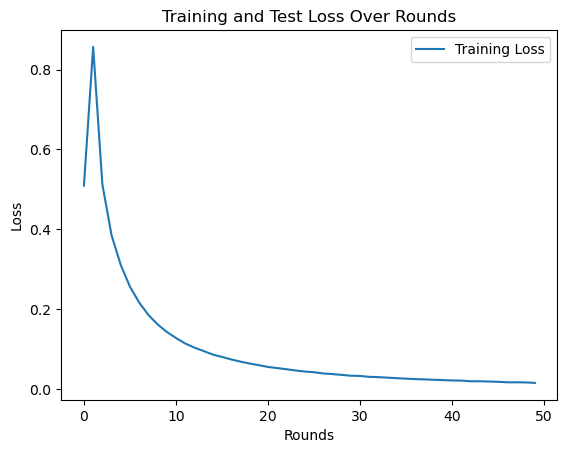

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_train, label='Training Loss')
#plt.plot(loss_test, label='Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Rounds')
plt.legend()
plt.show()

In [ ]:
selected_clients

array([8, 6, 3, 2, 0, 7, 9, 1, 4, 5])

In [ ]:
# Plotting the graphs
def plot_graphs(train_accuracy, test_accuracy, train_loss, test_loss):
    plt.figure(1, figsize=(10,6))
    plt.plot(train_accuracy, label='Train Accuracy', color='red', linewidth=2)
    plt.plot(test_accuracy, label='Test Accuracy', color='blue', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot")
    plt.legend()
    #plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(train_loss, label='Train loss', color='r', linewidth=2)
    plt.plot(test_loss, label='Test loss', color='b', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Epoch Loss Plot")
    plt.legend()

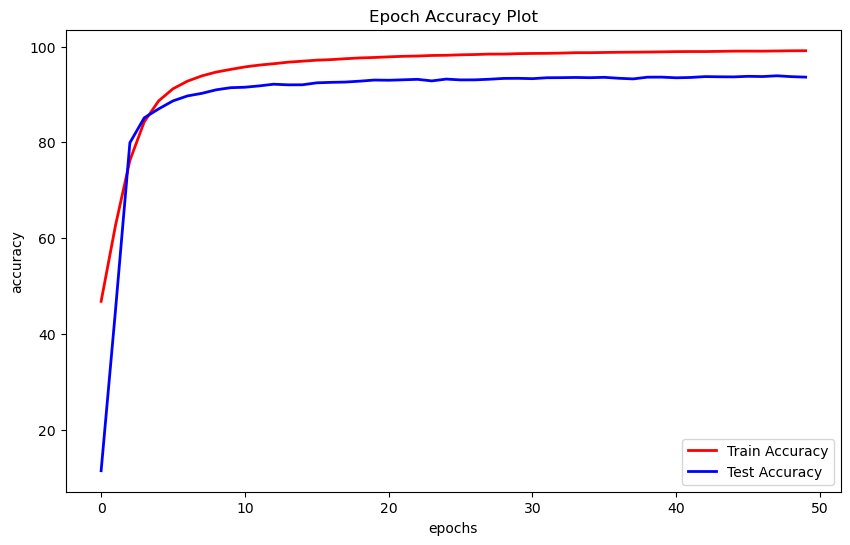

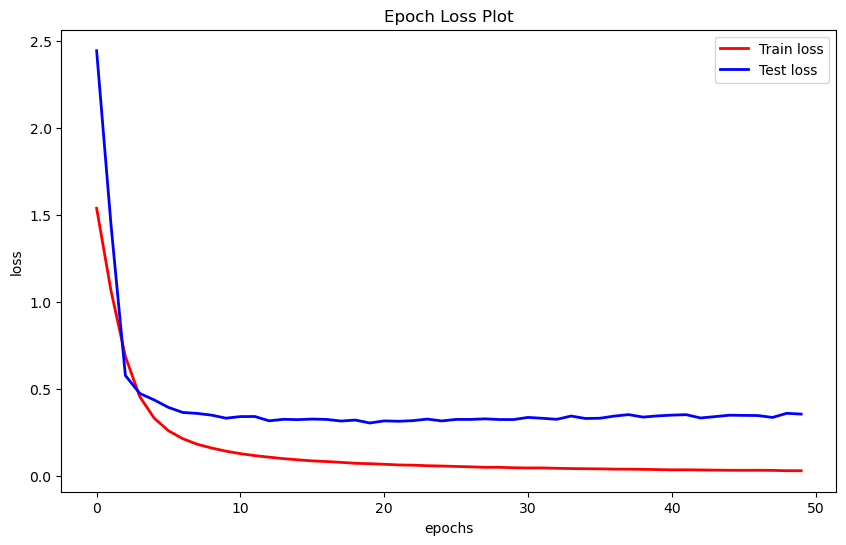

In [ ]:
plot_graphs(acc_train, acc_test, loss_train, loss_test)

In [ ]:
with open('FL_model_resnet9_overfit_train_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_train}\n")

In [ ]:
with open('FL_model_resnet9_overfit_test_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_test}\n")

In [ ]:
with open('FL_model_resnet9_overfit_train_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_train}\n")

In [ ]:
with open('FL_model_resnet9_overfit_test_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_test}\n")

In [ ]:
# import ast
# with open('test_accuracy.txt', 'r') as file:
#     loaded_t_acc = file.read()
# ast.literal_eval(loaded_t_acc)

In [ ]:
import os

model_path = '/content/drive/MyDrive/Colab Notebooks/FL_Base/global_model_weights_resnet18.pth'

# Initialize the model (make sure it has the same architecture as the saved weights)
loaded_model = ResNet18(
    in_channels=num_channels, num_classes=num_classes).to(device)

# Load model weights
loaded_model.load_state_dict(torch.load(model_path))
print(f'Model weights loaded from {model_path}')

In [ ]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [ ]:
# Use one batch for the attack
images, labels = next(iter(testloader))

In [ ]:
# Initialize dummy data
dummy_data = torch.randn_like(images, requires_grad=True, device=device)

# Define optimizer for the dummy data
optimizer = torch.optim.LBFGS([dummy_data], lr=0.01)

def closure():
    optimizer.zero_grad()
    dummy_outputs = global_model(dummy_data)
    dummy_loss = criterion(dummy_outputs, labels.to(device))
    dummy_loss.backward()
    return dummy_loss

# Optimize the dummy data
for it in range(300):  # Number of optimization iterations
    optimizer.step(closure)

    if it % 10 == 0:  # Print loss every 10 iterations
        current_loss = closure()
        print(f"Iteration {it}, Loss: {current_loss.item()}")

Iteration 0, Loss: 9.325345039367676
Iteration 10, Loss: 0.11462259292602539
Iteration 20, Loss: 0.00682041933760047
Iteration 30, Loss: 0.0005145419854670763
Iteration 40, Loss: 3.6379995435709134e-05
Iteration 50, Loss: 4.279410859453492e-06
Iteration 60, Loss: 4.279410859453492e-06
Iteration 70, Loss: 4.279410859453492e-06
Iteration 80, Loss: 4.279410859453492e-06
Iteration 90, Loss: 4.279410859453492e-06
Iteration 100, Loss: 4.279410859453492e-06
Iteration 110, Loss: 4.279410859453492e-06
Iteration 120, Loss: 4.279410859453492e-06
Iteration 130, Loss: 4.279410859453492e-06
Iteration 140, Loss: 4.279410859453492e-06
Iteration 150, Loss: 4.279410859453492e-06
Iteration 160, Loss: 4.279410859453492e-06
Iteration 170, Loss: 4.279410859453492e-06
Iteration 180, Loss: 4.279410859453492e-06
Iteration 190, Loss: 4.279410859453492e-06
Iteration 200, Loss: 4.279410859453492e-06
Iteration 210, Loss: 4.279410859453492e-06
Iteration 220, Loss: 4.279410859453492e-06
Iteration 230, Loss: 4.279410

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


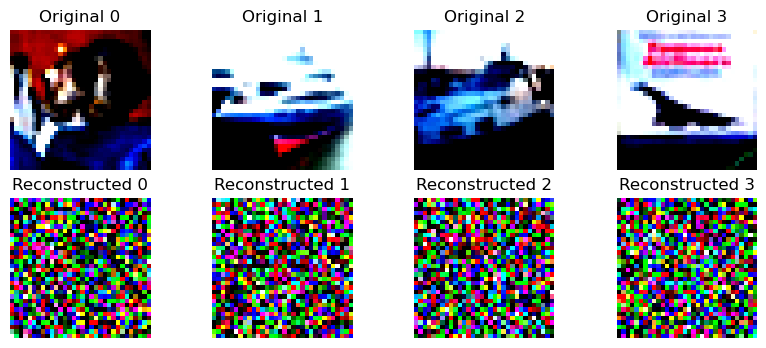

In [ ]:
import matplotlib.pyplot as plt

# Move dummy data to CPU and remove gradients for visualization
reconstructed = dummy_data.detach().cpu()

# Visualize some original and reconstructed images
fig, axs = plt.subplots(2, 4, figsize=(10, 4))
for i in range(4):
    axs[0, i].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    axs[0, i].title.set_text(f"Original {i}")
    axs[0, i].axis('off')

    axs[1, i].imshow(np.transpose(reconstructed[i].numpy(), (1, 2, 0)))
    axs[1, i].title.set_text(f"Reconstructed {i}")
    axs[1, i].axis('off')
plt.show()

In [ ]:
import ast
with open('test_loss.txt', 'r') as file:
    loaded_t_acc = file.read()
fl_loss = ast.literal_eval(loaded_t_acc)

In [ ]:
import ast
with open('central_test_loss.txt', 'r') as file:
    loaded_t_acc = file.read()
centralized_loss = ast.literal_eval(loaded_t_acc)

In [ ]:
import ast
with open('test_loss_ps.txt', 'r') as file:
    loaded_t_acc = file.read()
ps_loss = ast.literal_eval(loaded_t_acc)

In [ ]:
import ast
with open('test_loss_ps_2.txt', 'r') as file:
    loaded_t_acc = file.read()
ps_loss_2 = ast.literal_eval(loaded_t_acc)

In [ ]:
import matplotlib.pyplot as plt
from typing import List
def plot_ndcg(epochs: int, central_loss: List[float], fed_loss: List[float], ps_loss):
    """
    Plots training loss across epochs for two different models.

    :param epochs: Number of global training epochs
    :param loss1: List of loss per global epoch for the first model
    :param loss2: List of loss per global epoch for the second model
    :param num_clients: Number of clients sampled per epoch
    """
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(epochs)), central_loss, label='Centralized Model', color="blue")
    plt.plot(list(range(epochs)), fed_loss, label='FL', color="red")
    plt.plot(list(range(epochs)), ps_loss, label='FL with partial Sharing', color="green")
    plt.ylim(0.0, 3.5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss per epoch')
    plt.legend()
    plt.show()

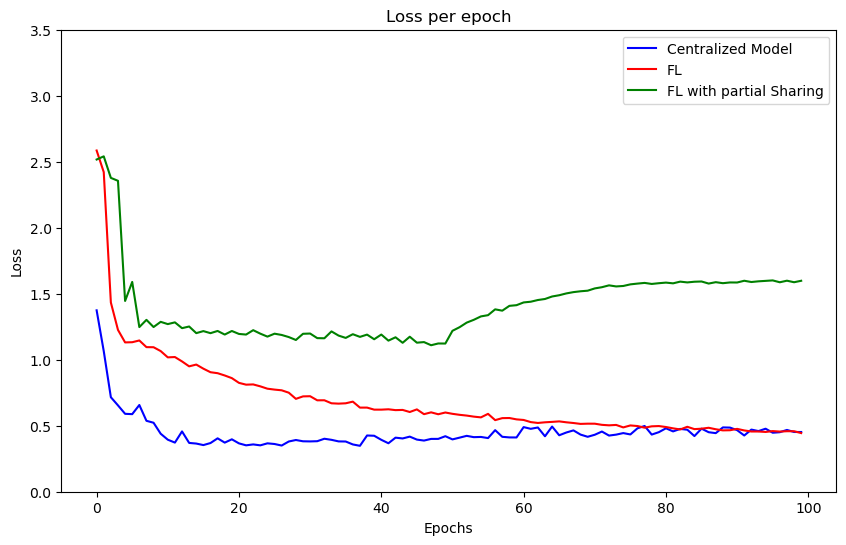

In [ ]:
plot_ndcg(100, centralized_loss[:100], fl_loss[:100], ps_loss_2)